<a href="https://colab.research.google.com/github/DanbiAubrey/RNN/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [데이터 전처리]

## 나라별 이름 text 데이터 다운로드

#### - file name: 각 나라 ex) Italian
#### - each row in file: 해당 국가의 성(Family name)

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip

--2025-02-27 03:02:40--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.72, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2025-02-27 03:02:41 (22.8 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [4]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


## Family name을 유니코드에서 ASCII 코드로 변환

#### 1) total 18 국가의 Family name 파일 찾아서 리스트에 저장

In [24]:
from glob import glob

file_list = glob('data/names/*.txt')
n_countries = len(file_list)
print("number of countries: {}".format(n_countries))

number of countries: 18


#### 2) 특수 문자나 발음 구별 기호를 Family name 에서 제거

In [25]:
import string
import unicodedata

alphs = string.ascii_letters + " .,;'"
n_alphs = len(alphs)
print("number of alphabets:{}".format(n_alphs))

number of alphabets:57


In [26]:
def unicodeToAscii(word):
  ascii_word = []
  for char in unicodedata.normalize("NFD", word): # base character + combining character
    if char in alphs and unicodedata.category(char) != "Mn": # 발음 구별 기호 제거하고 알파벳만
      ascii_word.append(char)

  return ''.join(ascii_word)

In [27]:
# 파일을 읽어서 이름의 char들을 알파벳으로 변환
def readLines(file):
  names = []
  lines = open(file, encoding='utf-8').read().strip().split("\n")
  for line in lines:
    names.append(unicodeToAscii(line))
  return names

In [28]:
import os

namesxcountry_dict = {}
countries = []

for file in file_list:
  country = os.path.splitext(os.path.basename(file))[0]
  countries.append(country)
  namesxcountry_dict[country] = readLines(file)

In [29]:
print(f"number of countries: {len(countries)}", end = "\n\n")
print(f"countries:{countries}", end="\n\n")
print("Family names in Korea: {}".format(namesxcountry_dict["Korean"]))

number of countries: 18

countries:['French', 'Irish', 'German', 'Japanese', 'Scottish', 'Russian', 'Czech', 'Arabic', 'Portuguese', 'Greek', 'Vietnamese', 'Korean', 'Polish', 'English', 'Spanish', 'Italian', 'Dutch', 'Chinese']

Family names in Korea: ['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin', 'Cho', 'Choe', 'Choi', 'Chong', 'Chou', 'Chu', 'Chun', 'Chung', 'Chweh', 'Gil', 'Gu', 'Gwang ', 'Ha', 'Han', 'Ho', 'Hong', 'Hung', 'Hwang', 'Hyun ', 'Jang', 'Jeon', 'Jeong', 'Jo', 'Jon', 'Jong', 'Jung ', 'Kang', 'Kim', 'Ko', 'Koo', 'Ku', 'Kwak', 'Kwang ', 'Lee', 'Li', 'Lim ', 'Ma', 'Mo', 'Moon', 'Nam', 'Ngai', 'Noh', 'Oh ', 'Pae', 'Pak', 'Park ', 'Ra', 'Rhee', 'Rheem', 'Ri', 'Rim', 'Ron', 'Ryom', 'Ryoo', 'Ryu', 'San', 'Seo', 'Seok', 'Shim', 'Shin', 'Shon', 'Si', 'Sin', 'So', 'Son', 'Song', 'Sook', 'Suh', 'Suk', 'Sun', 'Sung', 'Tsai ', 'Wang', 'Woo', 'Yang', 'Yeo', 'Yeon', 'Yi', 'Yim', 'Yoo', 'Yoon', 'You', 'Youj', 'Youn', 'Yu', 'Yun']


#### 3) Family name들을 one-hot encoding

In [30]:
import torch

def alph2idx(char):
    return alphs.find(char)

def alph2tensor(char):
    tensor = torch.zeros(1, n_alphs)
    tensor[0][alph2idx(char)] = 1

    return tensor

def word2tensor(word):
    tensor = torch.zeros(len(word), 1, n_alphs)
    for idx, char in enumerate(word):
        tensor[idx][0][alph2idx(char)] = 1
    return tensor

# [RNN 모델]

In [33]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input2hidden = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.hidden2output = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.input2hidden(combined)
        hidden = torch.tanh(hidden)
        output = self.hidden2output(hidden)

        return output, hidden

    def initial_hidden(self):
        return torch.zeros(1, self.hidden_dim)

In [34]:
# 모델 생성
rnn = RNN(len(alphs), 128, n_countries)

In [36]:
import random

def extractRandomData():
    country = random.choice(countries)
    word = random.choice(namesxcountry_dict[country])
    country_tensor = torch.tensor([countries.index(country)], dtype=torch.long)
    word_tensor = word2tensor(word)

    return country, word, country_tensor, word_tensor

for _ in range(5):
    country, word, country_tensor, word_tensor = extractRandomData()
    print('country =', country, '/ word =', word, '/ country_tensor =', country_tensor)

country = Vietnamese / word = Trieu / country_tensor = tensor([10])
country = Polish / word = Serafin / country_tensor = tensor([12])
country = Czech / word = Skala / country_tensor = tensor([6])
country = Chinese / word = Luo / country_tensor = tensor([17])
country = Japanese / word = Baisotei / country_tensor = tensor([3])


In [37]:
# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

def train(country_tensor, word_tensor):
    optimizer.zero_grad()
    hidden = rnn.initial_hidden()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    loss = loss_fn(output, country_tensor)

    loss.backward()

    optimizer.step()

    return output, loss.item()

In [38]:
# 100,000 개의 training data
import time
import math

iteration = 100000
print_iter = 5000
plot_iter = 1000

cur_loss = 0
losses = []

def output2country(output):
    top_val, top_idx = output.topk(1)
    country_idx = top_idx[0].item()
    return countries[country_idx], country_idx

for i in range(1, iteration+1):
    country, word, country_tensor, word_tensor = extractRandomData()
    output, loss = train(country_tensor, word_tensor)
    cur_loss += loss

    if i % print_iter == 0:
        pred, pred_idx = output2country(output)
        if pred == country:
            correct = 'correct!'
        else:
            correct = 'wrong (%s)' % country
        print('iteration: %d loss: %.5f Family name: %s / Predicted name: %s %s' % (i, loss, word, pred, correct))

    if i % plot_iter == 0:
        losses.append(cur_loss / plot_iter)
        cur_loss = 0

iteration: 5000 loss: 3.11862 Family name: Fleming / Predicted name: Dutch wrong (Scottish)
iteration: 10000 loss: 0.41482 Family name: Usami / Predicted name: Japanese correct!
iteration: 15000 loss: 0.33166 Family name: Kudo / Predicted name: Japanese correct!
iteration: 20000 loss: 1.17109 Family name: D'cruz / Predicted name: Portuguese wrong (Spanish)
iteration: 25000 loss: 0.19254 Family name: Toma / Predicted name: Arabic correct!
iteration: 30000 loss: 1.23230 Family name: Leclair / Predicted name: Scottish wrong (French)
iteration: 35000 loss: 2.47463 Family name: Orwin / Predicted name: Irish wrong (English)
iteration: 40000 loss: 0.43100 Family name: Gaspar / Predicted name: Portuguese correct!
iteration: 45000 loss: 1.17356 Family name: Shima / Predicted name: Japanese wrong (Czech)
iteration: 50000 loss: 2.49023 Family name: Rawlinson / Predicted name: Scottish wrong (English)
iteration: 55000 loss: 1.11204 Family name: Roma / Predicted name: Spanish correct!
iteration: 60

In [71]:
def predict(input_word, n_preds=3):
  print(f'input word:{input_word}')

  with torch.no_grad():
    output = torch.softmax(evaluate(word2tensor(input_word)), 1)

    top_v, top_idx = output.topk(n_preds, 1, True)
    predictions = []

    for i in range(n_preds):
      value = top_v[0][i].item()
      country_idx = top_idx[0][i].item()
      print(f"top-{i} score:{value:.4f}/ country: {countries[country_idx]}")
      predictions.append([value, countries[country_idx]])
  print("\n")

predict("Kim")
predict("Stone")
predict("Gao")

input word:Kim
top-0 score:0.5930/ country: Korean
top-1 score:0.3254/ country: Vietnamese
top-2 score:0.0199/ country: Arabic


input word:Stone
top-0 score:0.3121/ country: English
top-1 score:0.2872/ country: Dutch
top-2 score:0.1036/ country: German


input word:Gao
top-0 score:0.9873/ country: Chinese
top-1 score:0.0119/ country: Vietnamese
top-2 score:0.0008/ country: Korean




<ipython-input-42-d7625777ae66>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + countries, rotation=90)
<ipython-input-42-d7625777ae66>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + countries)


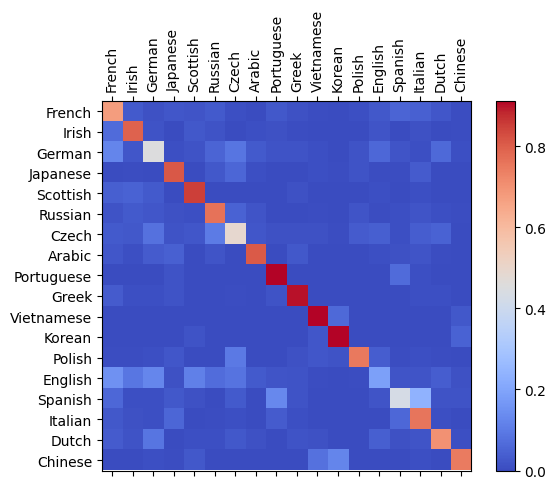

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

confusion = torch.zeros(n_countries, n_countries)
n_confusion = 10000

def evaluate(word_tensor):
  hidden = rnn.initial_hidden()

  for i in range(word_tensor.size()[0]):
    output, hidden = rnn(word_tensor[i], hidden)

  return output

for i in range(n_confusion):
  country, word, country_tensor, word_tensor = extractRandomData()
  output = evaluate(word_tensor)
  pred, pred_idx = output2country(output)
  country_idx = countries.index(country)
  confusion[country_idx][pred_idx] += 1


for i in range(n_countries):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy(), cmap=)
fig.colorbar(cax)

ax.set_xticklabels([''] + countries, rotation=90)
ax.set_yticklabels([''] + countries)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

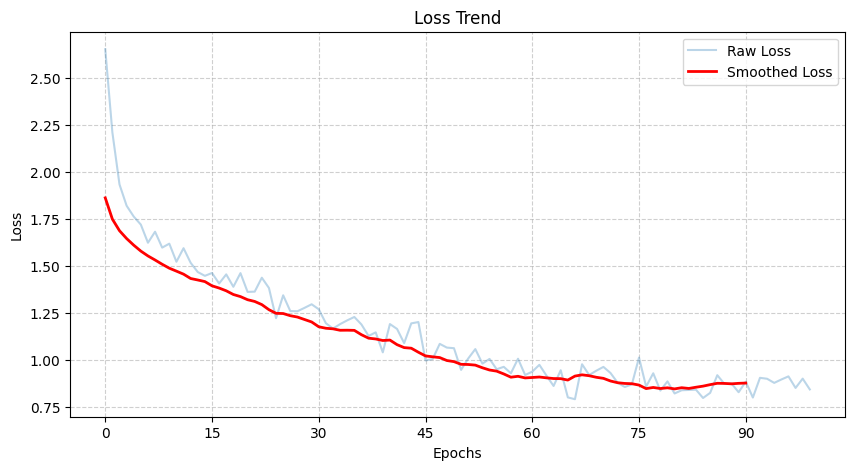

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def smooth_curve(points, window_size=10):
    return np.convolve(points, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = smooth_curve(losses, window_size=10)

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Raw Loss", alpha=0.3)
plt.plot(range(len(smoothed_losses)), smoothed_losses, label="Smoothed Loss", linewidth=2, color='red')  # 부드러운 곡선

plt.title("Loss Trend")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()
